In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import save_image

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import itertools

In [2]:
batch_size = 100
n_noise = 100
n_channel = 1

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

train_data = datasets.MNIST(root='../../datasets/MNIST', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../../datasets/MNIST', train=False, download=True, transform=transform)

In [4]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(112, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Linear(1024, 128*7*7),
            nn.BatchNorm1d(128*7*7),
            nn.ReLU()
        )
    
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.fc(x)
        x = x.reshape(-1, 128, 7, 7)
        x = self.deconv(x)
        
        return x

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(128*7*7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
        )
        
        self.fc2 = nn.Linear(1024, 1)
        
    def forward(self, x):
        x = self.conv(x)
        x = x.reshape(-1, 128*7*7)
        x = self.fc1(x)
        out_fc = self.fc2(x)
        out_proba = F.sigmoid(out_fc)
        
        return out_proba, out_fc, x



In [7]:
class netQ(nn.Module):
    def __init__(self):
        super(netQ, self).__init__()
        
        self.fc1 = nn.Sequential(
            nn.Linear(1024, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1)
        )
        
        self.fc2 = nn.Linear(64, 12)
        
    def forward(self, x):
        x = self.fc1(x)
        out_fc = self.fc2(x)
        out_proba = F.softmax(out_fc[:, :10])
        
        return out_proba, out_fc
            

In [8]:
def get_noise(batch_size, n_noise):
    z = np.random.randn(batch_size, n_noise)
    z = torch.from_numpy(z)
    return Variable(z)

def get_cont(batch_size, dim):
    return torch.Tensor(np.random.randn(batch_size, dim) * 0.5 + 0.0)


def get_dist(batch_size, n_classes=10):
    code = np.zeros((batch_size, n_classes))
    tmp = np.random.randint(0, n_classes, batch_size)
    
    for i in range(batch_size):
        code[i][tmp[i]] = 1
    
    return code, tmp

In [9]:
code = np.zeros((5, 10))
random_cate = np.random.randint(0, 10, 5)
code[range(5), random_cate] = 1
code = code.astype(np.float32)
code = torch.from_numpy(code)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

G = Generator()
G = G.to(device)

D = Discriminator()
D = D.to(device)

Q = netQ()
Q = Q.to(device)


BCE = nn.BCELoss()
CE = nn.CrossEntropyLoss()
MSE = nn.MSELoss()

optimizerG = optim.Adam(G.parameters(), lr = 0.001)
optimizerD = optim.Adam(D.parameters(), lr = 0.0002)
optimizerQ = optim.Adam(itertools.chain(G.parameters(), D.parameters(),Q.parameters()), lr=0.001)

noise = get_noise(batch_size, 100)


In [11]:
fixed_noise = get_noise(batch_size, n_noise).float().to(device)

start_time = time.time()

for epoch in range(100):
    s_time = time.time()
    for data, target in train_loader:
        G.train()
        train_x, train_y = data.to(device), target.to(device)
        noise = get_noise(batch_size, n_noise).float()
#         c_noise = get_cont(batch_size, 2).float().to(device)
#         d_noise = get_dist(batch_size, 10).float().to(device)
        
        # c1 : one-hot encoding 형식의 noise label
        # c_dist_class : noise label
        c1, c_dist_class = get_dist(batch_size)
        c1 = torch.FloatTensor(c1)
        c_dist_class = torch.LongTensor(c_dist_class)
        c2 = torch.FloatTensor(get_cont(batch_size, 1))
        c3 = torch.FloatTensor(get_cont(batch_size, 1))
        
        c_cont = torch.cat([c2,c3], 1)
        c = torch.cat([c1, c_cont], 1)
        noise = torch.cat([noise, c], 1).to(device)
        
        #train D
        optimizerD.zero_grad()
        d_real_output, _, _ = D(train_x)
        d_real_loss = BCE(d_real_output, torch.ones(batch_size).to(device))
        
        
        d_fake = G(noise).detach()
        d_fake_output, _, _ = D(d_fake)
        d_fake_loss =BCE(d_fake_output, torch.zeros(batch_size).to(device))
        
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimizerD.step()
        
        
        #train G
        optimizerG.zero_grad()
        g_gen = G(noise)
        d_gen, _, _= D(g_gen)
        
        g_loss = BCE(d_gen, torch.ones(batch_size).to(device))
        g_loss.backward()
        optimizerG.step()
        
        
        
        #train Q
        Q.zero_grad()
        D.zero_grad()
        G.zero_grad()
        
        # c_logit_fake : c1 noise의 softmax
        # c_fake : c1+c2+c3 noise
        
        _, _, output = D(G(noise))
        c_logit_fake, c_fake = Q(output)
        
        c_dist_est = c_logit_fake
        q_dist_loss = CE(c_dist_est, Variable(c_dist_class).cuda())
        
        c_cont_est = c_fake[:, -2:]
        q_cont_loss = MSE(c_cont_est, Variable(c_cont).cuda())
        
        q_loss = q_dist_loss + q_cont_loss
        q_loss.backward()
        optimizerQ.step()
        
        

    e_time = time.time()
    G.eval()
    
    print('epoch :', epoch, '\tloss_D :',d_loss.item(), '\tloss_G :',g_loss.item(),'\tloss_Q :',q_loss.item() ,'\ttime :',(e_time-s_time))
    
    tmp = np.zeros((n_noise, 2))
    for k in range(10):
        tmp[k*10:(k+1)*10, 0] = np.linspace(-2,2, 10)
    cc = torch.Tensor(tmp).float().to(device)

    tmp = np.zeros((n_noise, 10))
    for k in range(10):
        tmp[k*10:(k+1)*10, k] = 1
    dc = torch.Tensor(tmp).float().to(device)

    images = G(torch.cat([fixed_noise, dc, cc], 1))
    fig, ax = plt.subplots(10, 10, figsize=(15,15))
    for i in range(10):
        for j in range(10):
            ax[i][j].set_axis_off()
            ax[i][j].imshow(images[i*10+j].cpu().data.numpy().reshape(28, 28))
    plt.savefig('./InfoGAN_pytorch_MNIST_samples/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
    plt.close()

end_time = time.time()

print('Elapsed Time : %.3f'%(end_time - start_time))
        

C:\Users\my\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\my\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\my\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


epoch : 0 	loss_D : 1.1422302722930908 	loss_G : 0.8565304279327393 	loss_Q : 1.57481050491333 	time : 41.339402198791504
epoch : 1 	loss_D : 1.1342867612838745 	loss_G : 0.9081636667251587 	loss_Q : 1.5328454971313477 	time : 41.198737382888794
epoch : 2 	loss_D : 1.146058201789856 	loss_G : 0.8629401326179504 	loss_Q : 1.5247734785079956 	time : 41.38235783576965
epoch : 3 	loss_D : 1.2200772762298584 	loss_G : 0.8378484845161438 	loss_Q : 1.50124990940094 	time : 42.61497235298157
epoch : 4 	loss_D : 1.2455155849456787 	loss_G : 0.767700731754303 	loss_Q : 1.5199635028839111 	time : 42.2440984249115
epoch : 5 	loss_D : 1.2004878520965576 	loss_G : 0.8593823909759521 	loss_Q : 1.5008223056793213 	time : 41.71291446685791
epoch : 6 	loss_D : 1.272927165031433 	loss_G : 0.7802969217300415 	loss_Q : 1.4977383613586426 	time : 41.445136070251465
epoch : 7 	loss_D : 1.292033314704895 	loss_G : 0.7983331084251404 	loss_Q : 1.502315640449524 	time : 41.523683309555054
epoch : 8 	loss_D : 1.

### Save models

In [27]:
torch.save(D, './saved_model/InfoGAN_pytorch_MNIST/InfoGAN_pytorch_MNIST_D.pt')
torch.save(G, './saved_model/InfoGAN_pytorch_MNIST/InfoGAN_pytorch_MNIST_G.pt')
torch.save(Q, './saved_model/InfoGAN_pytorch_MNIST/InfoGAN_pytorch_MNIST_Q.pt')

## Test Generator

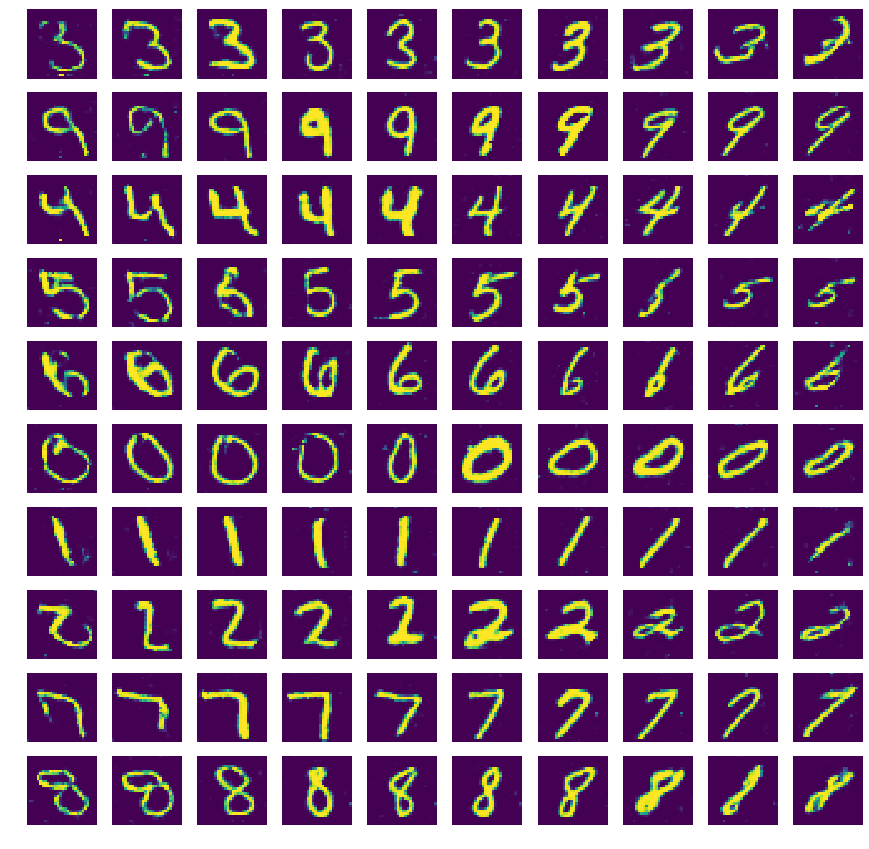

In [30]:
G.eval()
# fixed_noise = get_noise(batch_size, n_noise).float().to(device)
tmp = np.zeros((n_noise, 2))

for k in range(10):
    tmp[k*10:(k+1)*10, 0] = np.linspace(-2,2, 10)
cc = torch.Tensor(tmp).float().to(device)

tmp = np.zeros((n_noise, 10))
for k in range(10):
    tmp[k*10:(k+1)*10, k] = 1
dc = torch.Tensor(tmp).float().to(device)

images = G(torch.cat([fixed_noise, dc, cc], 1))
fig, ax = plt.subplots(10, 10, figsize=(15,15))
for i in range(10):
    for j in range(10):
        ax[i][j].set_axis_off()
        ax[i][j].imshow(images[i*10+j].cpu().data.numpy().reshape(28, 28))